# PuppySense

인공지능응용 프로젝트

모델학습 (colab 환경설정, 전이 학습 설정 진행)






## 1. Colab 환경설정 (GPU + 라이브러리 설치)

In [1]:
!pip install tensorflow opencv-python matplotlib
!pip install efficientnet
!pip install pandas numpy opencv-python tensorflow kagglehub
!pip install scikit-learn



# 2. 데이터 전처리하기

## 2.1 kaggle 데이터 다운하기

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import kagglehub

# 1. kagglehub로 실제 경로 다운로드
path = kagglehub.dataset_download("danielshanbalico/dog-emotion")
data_dir = os.path.join(path, 'Dog Emotion')
print("실제 다운로드된 경로:", path)
print("해당 경로 내 파일/폴더:", os.listdir(path))




c:\Users\oculo\Desktop\test\artificialin\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


실제 다운로드된 경로: C:\Users\oculo\.cache\kagglehub\datasets\danielshanbalico\dog-emotion\versions\1
해당 경로 내 파일/폴더: ['Dog Emotion']


## 2.2 데이터 로드


In [3]:
# 2. labels.csv 경로
labels_csv_path = os.path.join(data_dir, 'labels.csv')
labels_df = pd.read_csv(labels_csv_path)

# 3. 감정 레이블 폴더 이름 불러오기
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
print(f'클래스 목록: {class_names}')

# 4. 레이블 매핑
label_map = {name: idx for idx, name in enumerate(class_names)}

# 5. 이미지 로딩 함수
def load_and_preprocess_img(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"이미지 파일을 불러올 수 없습니다: {img_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = img / 255.0
    return img

# 6. 이미지 및 레이블 로딩
images, labels = [], []
for _, row in labels_df.iterrows():
    img_path = os.path.join(data_dir, row['label'], row['filename'])
    img = load_and_preprocess_img(img_path)
    if img is not None:
        images.append(img)
        labels.append(label_map[row['label']])

# 7. 배열 및 one-hot 인코딩
images = np.array(images)
labels = tf.keras.utils.to_categorical(labels, num_classes=len(class_names))

# 8. 확인
print(f'이미지 개수: {images.shape[0]}, 라벨 개수: {labels.shape[0]}')
print(f'라벨 예시 (one-hot):\n{labels[:5]}')

클래스 목록: ['angry', 'happy', 'relaxed', 'sad']
이미지 개수: 4000, 라벨 개수: 4000
라벨 예시 (one-hot):
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


# 3. test, valid, train set 나누기

In [4]:
from sklearn.model_selection import train_test_split

# 1) train+val / test 분리 (10%를 test로 분리)
train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    images, labels, test_size=0.1, random_state=42, stratify=labels
)

# 2) train / val 분리 (train_val 중 10%를 validation으로 분리)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=0.1, random_state=42, stratify=train_val_labels
)


# 4. 전이 학습 모델 구성 (EfficientNetB4 사용)

## 4.1 Feature Extracter로 사전 학습

이미지넷으로 이미 학습된 가중치를 그대로 활용하기 위해서 Feature Extrator를 사용합니다. EfficientNetB0은 선, 모양 색 변화 등 저 수준의 특징을 추출하는 하위층과 귀,입, 꼬리 등 물체의 일부를 감지하는 중간 층, 그리고 전체 물체와 감정등을 추론하는 상위층으로 이루어져 있습니다.Feature Extractor에서 하위, 중간층만 그대로 받아옵니다.

In [ ]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2  # ✅ L2 정규화 임포트

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)

base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224,224, 3))
base_model.trainable = False  # 처음엔 학습하지 않음 (Feature Extractor로 사용)

inputs = Input(shape=(224,224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.6)(x)

outputs = Dense(len(class_names), activation='softmax', kernel_regularizer=l2(0.0001))(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 1차 학습 (기본 모델 고정)
hist = model.fit(
    train_images, train_labels,
    epochs=15,
    validation_data=(val_images, val_labels),
    callbacks=[early_stop, reduce_lr]
)



Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 111s 961ms/step - accuracy: 0.2473 - loss: 1.4368 - val_accuracy: 0.2500 - val_loss: 1.3948 - learning_rate: 0.0010
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 94s 919ms/step - accuracy: 0.2538 - loss: 1.4337 - val_accuracy: 0.2500 - val_loss: 1.4060 - learning_rate: 0.0010
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 94s 923ms/step - accuracy: 0.2574 - loss: 1.4219 - val_accuracy: 0.2500 - val_loss: 1.3960 - learning_rate: 0.0010
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 94s 921ms/step - accuracy: 0.2492 - loss: 1.4144 - val_accuracy: 0.2556 - val_loss: 1.3980 - learning_rate: 0.0010
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 96s 938ms/step - accuracy: 0.2356 - loss: 1.4217 - val_accuracy: 0.2750 - val_loss: 1.3877 - learning_rate: 3.0000e-04
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 96s 938ms/step - accuracy: 0.2602 - loss: 1.4194 - val_accuracy: 0.2528 - val_loss: 1.3880 - learning_rate: 3.0000e-04
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 96s 937ms/step - accu

## 4.2 상위층 학습

In [7]:
# base_model의 일부 층부터 학습 가능하게 설정
base_model.trainable = True

# (선택) 특정 층까지만 학습되도록 설정하고 싶을 때:
# fine_tune_at = 100
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False

# 컴파일 다시 (학습 가능한 가중치가 생겼기 때문)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # 전이학습엔 낮은 학습률이 중요
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 2차 학습 (전이 학습)
hist_fine = model.fit(
    train_images, train_labels,
    epochs=20,
    validation_data=(val_images, val_labels),
        callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 661s 6s/step - accuracy: 0.2945 - loss: 1.4275 - val_accuracy: 0.2500 - val_loss: 1.4229 - learning_rate: 1.0000e-05
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 618s 6s/step - accuracy: 0.3672 - loss: 1.3200 - val_accuracy: 0.2472 - val_loss: 1.4140 - learning_rate: 1.0000e-05
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 607s 6s/step - accuracy: 0.4622 - loss: 1.2286 - val_accuracy: 0.2583 - val_loss: 1.4151 - learning_rate: 1.0000e-05
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 579s 6s/step - accuracy: 0.5048 - loss: 1.1529 - val_accuracy: 0.3611 - val_loss: 1.3233 - learning_rate: 1.0000e-05
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 579s 6s/step - accuracy: 0.5528 - loss: 1.0587 - val_accuracy: 0.4028 - val_loss: 1.2579 - learning_rate: 1.0000e-05
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 580s 6s/step - accuracy: 0.6073 - loss: 0.9766 - val_accuracy: 0.6028 - val_loss: 1.0713 - learning_rate: 1.0000e-05
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 581s 6s/step - acc

# 5. 데이터 증강학습

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,          # 회전
    width_shift_range=0.1,      # 가로 이동
    height_shift_range=0.1,     # 세로 이동
    shear_range=0.1,            # 전단
    zoom_range=0.2,             # 확대/축소
    horizontal_flip=True,       # 좌우 반전
    fill_mode='nearest'         # 빈 영역 보정 방식
)

train_generator = datagen.flow(train_images, train_labels, batch_size=8)

hist = model.fit(
    train_generator,
    epochs=15,
    validation_data=(val_images, val_labels),
    callbacks=[early_stop, reduce_lr],
    steps_per_epoch=len(train_images) // 8  # 증강은 batch 기반이라 꼭 필요함
)


c:\Users\oculo\Desktop\test\artificialin\.conda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 614s 1s/step - accuracy: 0.7422 - loss: 0.6442 - val_accuracy: 0.7694 - val_loss: 0.5999 - learning_rate: 1.0000e-05
Epoch 2/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 571s 1s/step - accuracy: 0.7566 - loss: 0.6343 - val_accuracy: 0.7917 - val_loss: 0.5930 - learning_rate: 1.0000e-05
Epoch 3/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 576s 1s/step - accuracy: 0.7756 - loss: 0.5711 - val_accuracy: 0.7500 - val_loss: 0.6646 - learning_rate: 1.0000e-05
Epoch 4/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 589s 1s/step - accuracy: 0.7861 - loss: 0.5439 - val_accuracy: 0.8056 - val_loss: 0.5515 - learning_rate: 1.0000e-05
Epoch 5/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 591s 1s/step - accuracy: 0.8003 - loss: 0.5094 - val_accuracy: 0.8083 - val_loss: 0.5326 - learning_rate: 1.0000e-05
Epoch 6/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 582s 1s/step - accuracy: 0.8257 - loss: 0.4685 - val_accuracy: 0.8056 - val_loss: 0.5153 - learning_rate: 1.0000e-05
Epoch 7/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 593s 1s/step - acc

# 6.테스트셋 평가

## 6.1 테스트셋 평가

In [9]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 816ms/step - accuracy: 0.8496 - loss: 0.4750
Test Accuracy: 0.8500, Test Loss: 0.4507


Keras 방식의 테스트 정확도 계산

In [10]:
import time
from datetime import datetime

start_time = time.time()
start_dt = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"실행 시작: {start_dt}")

# 평가
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f"테스트 정확도: {test_acc:.4f}")

end_time = time.time()
end_dt = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"실행 종료: {end_dt}")
print(f"총 실행 시간: {end_time - start_time:.2f}초")




실행 시작: 2025-06-01 04:44:59
테스트 정확도: 0.8500
실행 종료: 2025-06-01 04:45:10
총 실행 시간: 10.76초


## 6.2 모델저장

자신의 드라이브에 저장되는 것이므로 파일 저장후 공용드라이브로 옮겨주어야 합니다.

In [5]:
import os
import time
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 실행 시간 측정 시작
start_time = time.time()
start_dt = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"실행 시작: {start_dt}")

# 저장 디렉토리 설정
model_dir = "./0604models"

# 🔧 파일로 존재하는 경우 삭제
if os.path.exists(model_dir) and not os.path.isdir(model_dir):
    os.remove(model_dir)

# 디렉토리 생성
os.makedirs(model_dir, exist_ok=True)

# 오늘 날짜
today_str = datetime.now().strftime("%Y-%m-%d")

# 저장 경로들
keras_path = os.path.join(model_dir, f"puppySenseModel_{today_str}.keras")
h5_path = os.path.join(model_dir, f"puppySenseModel_{today_str}.h5")

# ✅ EfficientNetB4 기반 모델 정의
model = Sequential([
    EfficientNetB4(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg'
    ),
    Dense(4, activation='softmax')  # 예시: 감정 클래스 수가 4개일 경우
])

# ⚠️ EfficientNet 사용 시에는 일반적으로 분류 문제로 가정하고 compile
model.compile(optimizer='adam', loss='categorical_crossentropy')

# ✅ .keras 형식 저장
model.save(keras_path)
print(f"✅ .keras 형식으로 저장됨: {keras_path}")

# ✅ .h5 형식 저장
model.save(h5_path)
print(f"✅ .h5 형식으로 저장됨: {h5_path}")

# 실행 시간 측정 종료
end_time = time.time()
end_dt = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"실행 종료: {end_dt}")
print(f"총 실행 시간: {end_time - start_time:.2f}초")


실행 시작: 2025-06-04 19:09:26


✅ .keras 형식으로 저장됨: ./0604models\puppySenseModel_2025-06-04.keras
✅ .h5 형식으로 저장됨: ./0604models\puppySenseModel_2025-06-04.h5
실행 종료: 2025-06-04 19:09:29
총 실행 시간: 2.82초


In [12]:
import tensorflow as tf
import os
from datetime import datetime

# 1. Keras 모델 불러오기
keras_model_path = r"C:\Users\oculo\Desktop\2025-01\2025-01\인공지능응용\플젝 파일\models\puppySenseModel_2025-06-01.keras"
model = tf.keras.models.load_model(keras_model_path)

# 2. SavedModel 저장 경로 준비
save_dir = r"C:\Users\oculo\Desktop\2025-01\2025-01\인공지능응용\플젝 파일\tfmodels"
if os.path.exists(save_dir):
    if os.path.isfile(save_dir):
        os.remove(save_dir)
os.makedirs(save_dir, exist_ok=True)

today_str = datetime.now().strftime("%Y-%m-%d")
savedmodel_path = os.path.join(save_dir, f"puppySenseModel_{today_str}_savedmodel")

# 3. SavedModel 포맷으로 내보내기 (Keras 3.x)
model.export(savedmodel_path)
print(f"✅ SavedModel 포맷으로 저장됨: {savedmodel_path}")



c:\Users\oculo\Desktop\test\artificialin\.conda\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


FailedPreconditionError: C:\Users\oculo\Desktop\2025-01\2025-01\인공지능응용\플젝 파일\tfmodels is not a directory

## 6.3 시각화

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# 클래스 이름
class_names = ['angry', 'happy', 'relaxed', 'sad']

# 예측 확률
y_pred = model.predict(test_images)  # shape: (4000, 4)

# 예측 클래스 (argmax)
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(test_labels, axis=1)

# 이미지 10개 출력
fig = plt.figure(figsize=(15, 10))
for j in range(10):
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(test_images[j])  # 정규화된 이미지면 되돌리기

    true_label = class_names[y_true_class[j]]

    # 확률 리스트 문자열 생성
    prob_text = "\n".join([
        f"{class_names[i]}: {y_pred[j][i]*100:.1f}%" for i in range(len(class_names))
    ])

    # 텍스트 출력
    ax.text(
        0.5, -0.25,
        f"GT: {true_label}\n{prob_text}",
        size=12,
        ha='center',
        va='center',
        transform=ax.transAxes
    )

plt.tight_layout()
plt.show()


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 224, 224, 3), dtype=float32). Expected shape (None, 10), but input has incompatible shape (32, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 224, 224, 3), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

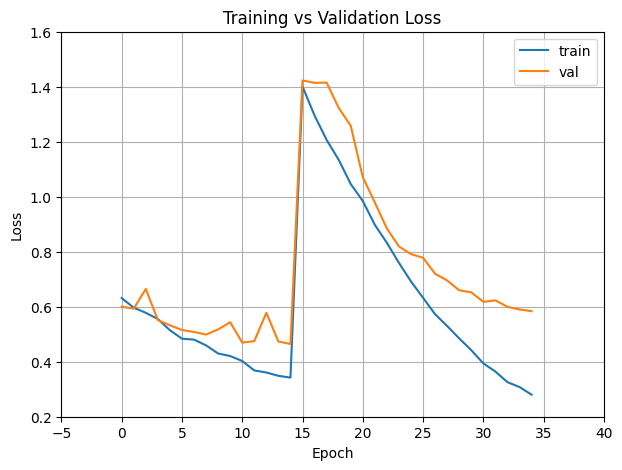

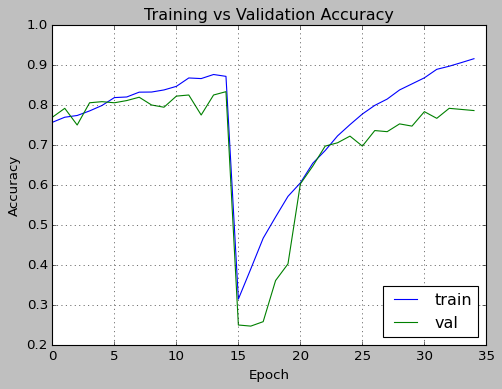

In [16]:
# 두 히스토리 합치기 (간단히 리스트 이어붙이기)
for key in hist_fine.history.keys():
    hist.history[key].extend(hist_fine.history[key])

# 이제 hist.history에 10 epoch의 기록이 모두 들어있음

# 에포크 수 및 히스토리 정보
epochs = len(hist.history['loss'])  # epochs 수를 자동으로 가져옵니다
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

# 손실 그래프
plt.figure(1, figsize=(7, 5))
plt.plot(xc, train_loss, label='train')
plt.plot(xc, val_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.legend()
plt.style.use(['classic'])

# 정확도 그래프
plt.figure(2, figsize=(7, 5))
plt.plot(xc, train_acc, label='train')
plt.plot(xc, val_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.legend(loc='lower right')
plt.style.use(['classic'])

plt.show()


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = model.predict(test_images)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(test_labels, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

# 혼동 행렬 시각화
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 224, 224, 3), dtype=float32). Expected shape (None, 10), but input has incompatible shape (32, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 224, 224, 3), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>